In [18]:
"The implementation is largely influenced by the Yen's algorithm in Wikipedia\
and beegeesquare's implementation on github"

import networkx as nx
from copy import deepcopy
import queue
import matplotlib.pyplot as plt
#import names
import csv
#import math
import numpy as np
import pandas as pd
nodes_file=csv.reader(open('nodes.csv','r'));
links_file=csv.reader(open('links.csv','r'));

In [7]:
G_network=nx.Graph()
G_risk_logit= nx.Graph()
G_risk_poisson= nx.Graph()
G_risk_xgboost= nx.Graph()
G_risk_ANN= nx.Graph()

In [8]:
tmp=0
for row in nodes_file:
    if (tmp>0):
        G_network.add_node(row[0])
        G_risk_logit.add_node(row[0])
        G_risk_poisson.add_node(row[0])
        G_risk_xgboost.add_node(row[0])
        G_risk_ANN.add_node(row[0])
        
        
    tmp=+1

In [9]:
tmp=0
for row in links_file:
    if (tmp>0): # Ignores the first line in the file
        G_network.add_edge(row[0],row[1]);
        G_network[row[0]][row[1]]['weight']=float(row[2]);
#        first risk model
        G_risk_logit.add_edge(row[0],row[1]);
        G_risk_logit[row[0]][row[1]]['weight']=float(row[3]);
#        second risk model
        G_risk_poisson.add_edge(row[0],row[1]);
        G_risk_poisson[row[0]][row[1]]['weight']=float(row[4]);
        G_risk_xgboost.add_edge(row[0],row[1]);
        G_risk_xgboost[row[0]][row[1]]['weight']=float(row[5]);
        G_risk_ANN.add_edge(row[0],row[1]);
        G_risk_ANN[row[0]][row[1]]['weight']=float(row[6]);
        
    tmp+=1;

In [10]:
#getEdge and drawP are for drawing
def getEdge(p):
   draw_edge = []
   for i in range(len(p)-1):
       a = (p[i],p[i+1])
       draw_edge.append(a)
   return draw_edge

In [11]:
# Draw the network if needed
def drawP(G_network,p,pos):
#    c,p = nx.single_source_dijkstra(G_network,"Ann_Arbor","Seattle")
    #print(p)
#    pos = nx.spring_layout(G_network)
    draw_edge = getEdge(p)      
    nx.draw_networkx_nodes(G_network, pos,
                           node_size=100,
                           alpha=0.8)
    nx.draw_networkx_nodes(G_network, pos,nodelist=p,
                           node_size=100,
                           alpha=0.8)
    nx.draw_networkx_edges(G_network, pos, width=1, alpha=0.5)
    nx.draw_networkx_edges(G_network, pos, edgelist=draw_edge, \
                           width=5, alpha=0.5,edge_color='r')
    nx.draw_networkx_labels(G_network, pos,font_size=12)

In [12]:
def pweight(G,p):
    w = 0;
    for i in range(len(p)-1): 
#        print(p[i])
        w += G[p[i]][p[i+1]]['weight'];
    return w

In [13]:
def cprm(G,a,z):
    ec = G[a][z]['weight'];
    G.remove_edge(a,z);
    return (a,z,ec)

In [14]:
def cprmnode(G,n):
    ec = deepcopy(G[n]);
    G.remove_node(n);
    return (n,ec)

In [16]:
def yen(G,source,target,K):
    # Determine the shortest path from the source to the sink.
    (c,p) = nx.single_source_dijkstra(G,source,target);
    A = [p];  A_cost = [c];
    # Initialize the set to store the potential kth shortest path.
    B = queue.PriorityQueue();
    for k in range(1,K):
        # The spur node ranges from the first node to the next to last node in the previous k-shortest path.
        for i in range(len(A[k-1])-1):
            
            # Spur node is retrieved from the previous k-shortest path, k − 1.
            sn = A[k-1][i];
            # The sequence of nodes from the source to the spur node of the previous k-shortest path.
            rp = A[k-1][:i];
            
            # We store the removed edges
            removed_edges = [];  removed_root_edges = [];  removed_root_nodes=[];
            # Remove the root paths

            # for each node rootPathNode in rootPath except spurNode:
            #   remove rootPathNode from Graph;
            for j in range(len(rp)):
                
                
                extra_edges = deepcopy(G.edges(rp[j]));
                
                for eg in extra_edges:
                  
                    src=eg[0];
                    tgt=eg[1];
                    removed_root_edges.append(cprm(G,src,tgt));
              
                removed_root_nodes.append(cprmnode(G,rp[j]));

            erp = A[k-1][:i+1];  # extended root path
            for p in A:
                if erp == p[:i+1] and G.has_edge(p[i],p[i+1]):
                    removed_edges.append(cprm(G,p[i],p[i+1]));
            # The spur path
            DONE = 0
            try:
                (csp,sp) = nx.single_source_dijkstra(G,sn,target)
            except:
                # there is no spur path if sn is not connected to the target
                sp = [];  csp = None; DONE = 1;
                #return (A, A_cost)
            # Add back the edges that were removed
            for nd in removed_root_nodes: G.add_node(nd[0]);
            for re in removed_root_edges: G.add_edge(re[0],re[1],weight=re[2]);
            for re in removed_edges: G.add_edge(re[0],re[1],weight=re[2]);
            if len(sp) > 0:
                # The potential k-th shortest path (the root path may be empty)
                pk = rp + sp;
#                print(pk)
                cpk = pweight(G,pk);
                # Add the potential k-shortest path to the heap
                B.put((cpk,pk));

        if B.empty():
            print ('There are only', k, 'shortest paths for this pair');
            break;
        # The shortest path in B that is not already in A is the new k-th shortest path
        while not B.empty():
            cost, path = B.get();
            if path not in A:
                A.append(path);
                A_cost.append(cost);
                break;

    return (A, A_cost)

[(['node 1', 'node 12', 'node 9', 'node 14'], 4500.0, 0.481840613, 1.311533533, 1.445882976, 0.165423199), (['node 1', 'node 7', 'node 10', 'node 4', 'node 14'], 4800.0, 0.5260691740000001, 2.166874902, 1.922017038, 0.0006658009999999999), (['node 1', 'node 11', 'node 10', 'node 4', 'node 14'], 4800.0, 0.573492701, 2.216023778, 1.92372024, 0.0006531610000000001), (['node 1', 'node 11', 'node 5', 'node 7', 'node 10', 'node 4', 'node 14'], 5600.0, 0.659954013, 2.2658244959999996, 2.88453871, 0.0006465358300000001)]


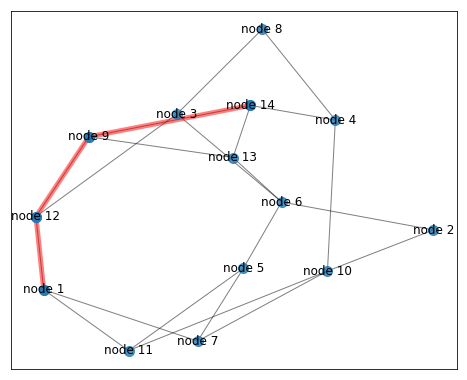

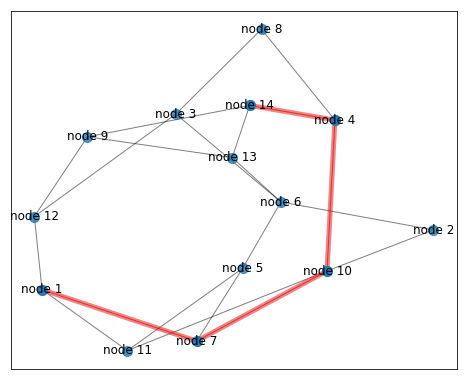

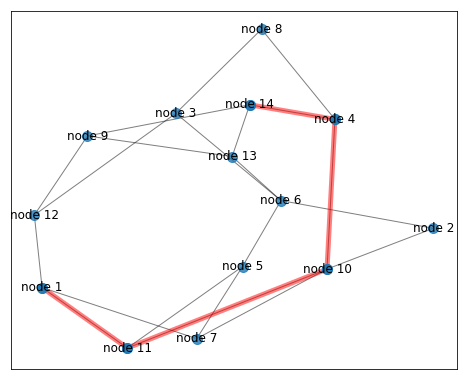

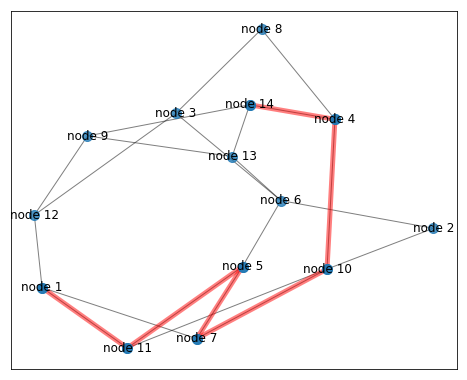

In [17]:
src='node 1';
tgt='node 14';
k=4;


k_path, path_costs=yen(G_network,src,tgt,k);
pos = nx.spring_layout(G_network)
result = []


for i in range(k):
#    print(k_path[i],path_costs[i])
    rank = i+1
    plt.figure(i+1,figsize=[8,6.6])
#    t = "This is the path ranked as {}"
#    plt.suptitle(t.format(rank))

    drawP(G_network,k_path[i],pos)
    
    if i == 0:
        plt.savefig('first.png', dpi = 1200)
    if i == 1:
        plt.savefig('second.png', dpi = 1200)
    if i == 2:
        plt.savefig('third.png', dpi = 1200)
    if i == 3:
        plt.savefig('four.png', dpi = 1200)
    if i == 4:
        plt.savefig('five.png', dpi = 1200)
        
    r1 = pweight(G_risk_logit,k_path[i])

    r2 = pweight(G_risk_poisson,k_path[i])

    r3 = pweight(G_risk_xgboost,k_path[i])

    r4 = pweight(G_risk_ANN,k_path[i])

    b = (k_path[i],path_costs[i],r1,r2,r3,r4)
    result.append(b)
print(result)    


df = pd.DataFrame(result,columns =['path','distance','risk_logit','risk_poi','risk_Xgboost','ANN'])

df.to_csv('result_k=4.csv')

